```
Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```


# SE3DS Perturbation Augmentation

[Paper](https://arxiv.org/abs/2204.02960) | [Video](https://www.youtube.com/watch?v=lhwwlrRfFp0)

This Colab demonstrates how to load and use a pretrained SE3DS model for the VLN perturbation augmentation used in our paper. This improves the success rate of an already strong VLN agent by up to 1.5%. This is part of the code for the paper "Simple and Effective Synthesis for 3D Scenes". The full codebase is found at https://github.com/google-research/se3ds/.

It is recommended that you run this Colab with a **GPU runtime**. You might get a warning about file space, but it will be resolved after the checkpoint is extracted / un-tarred.

## Download code, model weights, and install dependencies

In [ ]:
%%shell
echo
svn export --force https://github.com/google-research/se3ds/trunk se3ds
echo Installing required dependencies.
pip install -r se3ds/colab_requirements.txt

echo
echo Fetching trained model weights...
mkdir data
rm -f data/ckpt.tar
rm -rf data/ckpt/
wget https://storage.googleapis.com/gresearch/se3ds/mp3d_ckpt.tar -P data/
echo Extracting model weights...
tar -xf data/mp3d_ckpt.tar --directory data/
rm data/mp3d_ckpt.tar
echo Done.


Cloning into 'se3ds'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 53 (delta 10), reused 52 (delta 9), pack-reused 0
Unpacking objects: 100% (53/53), done.
Installing required dependencies.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 164 kB 13.7 MB/s 
     |████████████████████████████████| 4.1 MB 63.2 MB/s 
     |████████████████████████████████| 61 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 60.7 MB/s 
     |████████████████████████████████| 138 kB 76.3 MB/s 
     |████████████████████████████████| 224 kB 79.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uni

## Imports and utils

In [ ]:
import time
import tensorflow as tf
import math
import collections
import numpy as np
import os
import matplotlib.pyplot as plt

from se3ds import constants
from se3ds.inference import perturbation_utils
from se3ds.models import model_config
from se3ds.models import models
from se3ds.utils import utils
from se3ds.utils import pano_utils

devices = tf.config.experimental.list_logical_devices(device_type="GPU")
print([d.name for d in devices])
strategy = tf.distribute.MirroredStrategy(devices)

['/device:GPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Data

In [ ]:
image_size = 512
distance_per_frame = 0.1  # Distance between frames in metres.
update_every_dist = int(0.1 / distance_per_frame)  # Add points every x iteration.
num_context = 1  # How many frames to provide as context.
fps = 10  # How many frames per second to render videos at.

Load an example pano.

In [ ]:
%%bash
wget --no-check-certificate https://storage.googleapis.com/gresearch/pathdreamer/example_pano.tar -P data/
tar -xf data/example_pano.tar --directory data/

--2022-06-27 20:20:58--  https://storage.googleapis.com/gresearch/pathdreamer/example_pano.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1638400 (1.6M) [application/x-tar]
Saving to: ‘data/example_pano.tar’

     0K .......... .......... .......... .......... ..........  3% 53.9M 0s
    50K .......... .......... .......... .......... ..........  6% 35.0M 0s
   100K .......... .......... .......... .......... ..........  9% 56.5M 0s
   150K .......... .......... .......... .......... .......... 12% 52.0M 0s
   200K .......... .......... .......... .......... .......... 15% 77.0M 0s
   250K .......... .......... .......... .......... .......... 18% 95.2M 0s
   300K .......... .......... .......... .......... .......... 21% 81.3M 0s
   350K .......... .......... ........

In [ ]:
image_height = 512

# Load an example pano.
base_dir = 'data/example_pano/'
with tf.io.gfile.GFile(os.path.join(base_dir, 'rgb.jpeg'), 'rb') as f:
  input_rgb_frames = tf.image.decode_jpeg(f.read())
  input_rgb_frames = tf.image.resize(input_rgb_frames, (image_height, image_height * 2), method='bilinear')
  input_rgb_frames = tf.cast(input_rgb_frames, tf.uint8)
with tf.io.gfile.GFile(os.path.join(base_dir, 'depth_20.png'), 'rb') as f:
  input_depth_frames = tf.image.decode_png(f.read(), dtype=tf.uint16)
  input_depth_frames = tf.image.convert_image_dtype(input_depth_frames, tf.float32)
  input_depth_frames = tf.image.resize(input_depth_frames, (image_height, image_height * 2), method='nearest')
  input_depth_frames = tf.clip_by_value(input_depth_frames, 0, 1)

# Format example into (batch_size, height, width, channels) format.
input_rgb_frames = input_rgb_frames[None, ...]   # (1, 512, 1024, 3)
input_depth_frames = input_depth_frames[None, ..., 0]   # (1, 512, 1024)


# Set up a positions (xyz) tensor to indicate where to move to.
# z is up and y points towards the center of the equirectangular image.
positions = tf.constant(
    [[[-4.35156, -1.06265,  1.50841],
    [-3.02035, -0.99548,  1.51129],
    [-1.43824, -1.19414,  1.51526]]], tf.float32)  # (1, 3, 3)

## Image Generation

Run inference with a pretrained model.

In [ ]:
# Load a pretrained SE3DS model.
config = model_config.get_config()
stoch_model = models.SE3DSModel(config)

start_pos = positions[:, 0, :]
# input_seg is not used by the model, so we just pass a tensor of zeros.
input_seg = tf.zeros((1, image_size, image_size * 2, 1), tf.int32)  # (1, H, W, 1)
input_depth = input_depth_frames  # (1, H, W)
input_rgb = input_rgb_frames

num_samples = 5  # Number of random samples to generate for this pano.
xy_perturb = 1.5  # Maximum radius in meters to perturb.

_, height, width, _ = input_rgb.shape  # (1, H, W, 3)

# Reset and add context frames.
stoch_model.reset_memory()
stoch_model.add_to_memory(input_rgb, input_seg, input_depth, start_pos)


augmented_images = []
sample_idx = 0
while len(augmented_images) < num_samples:
  # Perturb position to augment pano.
  noise = tf.random.uniform(
      start_pos.shape,
      minval=[-xy_perturb, -xy_perturb, -0.1],
      maxval=[xy_perturb, xy_perturb, 0.1])
  
  # Use the depth to check whether this image intersects with any obstacles.
  display_depth = np.copy(input_depth[0, ...])
  proportion_invalid = perturbation_utils.get_proportion_invalid_for_depth(
      noise[0, :], display_depth, distance_padding=0.1)
  # Only compute if this perturbation does not cause significant collisions.
  if proportion_invalid < 0.02:
    curr_pos = start_pos + noise
    # Run inference to get RGB output.
    outputs = stoch_model(
        curr_pos, add_preds_to_memory=False)
    # Save perturbed and infilled image.
    image = tf.cast(outputs.pred_rgb.numpy()[0, ...], tf.uint8)
    augmented_images.append(image)

Restored from data/se3ds_ckpt


Display results as a figure.

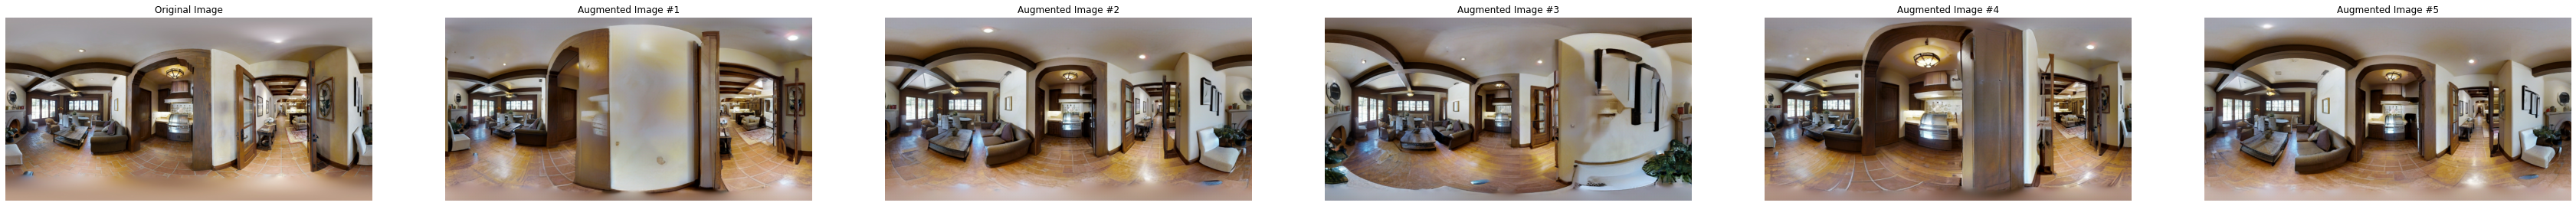

In [ ]:
size_scale = 5
num_display_items = len(augmented_images) + 1
fig, ax = plt.subplots(
    1, num_display_items,
    figsize=(2 * size_scale * num_display_items, size_scale))

_ = ax[0].imshow(input_rgb[0, ...])
ax[0].set_title('Original Image')
ax[0].axis('off')

for i in range(len(augmented_images)):
  _ = ax[i + 1].imshow(augmented_images[i])
  ax[i + 1].set_title(f'Augmented Image #{i+1}')
  ax[i + 1].axis('off')
plt.show()